# Capstone Final Assessment

In [1]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-11-17 20:44:18--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.07s   

2020-11-17 20:44:19 (305 KB/s) - ‘loan_train.csv’ saved [23101/23101]



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics, preprocessing, linear_model, neighbors, tree, svm, model_selection
from scipy.stats import zscore

In [2]:
table = pd.read_csv('loan_train.csv')
table.head(5)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


### Clean dataset and Encode data

In [3]:
table = table.drop(labels=['Unnamed: 0','Unnamed: 0.1','effective_date','due_date'],axis=1)

#Paid Encoding
PAID = preprocessing.LabelEncoder()
PAID.fit(table['loan_status'])
table['paid'] = PAID.transform(table['loan_status'])

#Gender Encoding
Gender = preprocessing.LabelEncoder()
table['gender'] = Gender.fit(table['Gender']).transform(table['Gender'])

#Edu Encoding
edu = preprocessing.LabelEncoder()
table['edu'] = edu.fit(table['education']).transform(table['education'])

#Principal Encoding
princ = preprocessing.LabelEncoder()
table['principal'] = princ.fit(table['Principal']).transform(table['Principal'])

#Turn terms and age into z-score evaluations
table['z_age'] = zscore(table['age'].to_numpy())
table['z_terms'] = zscore(table['terms'].to_numpy())

table = table.drop(labels=['loan_status','age','terms','Gender','education','Principal'],axis=1)
table.head()

,paid,gender,edu,principal,z_age,z_terms
0,1,1,1,4,2.331526,0.920718
1,1,0,0,4,0.341701,0.920718
2,1,1,3,4,-0.653211,-0.959111
3,1,0,3,4,-0.487392,0.920718
4,1,1,3,4,-0.321573,0.920718


In [4]:
xTrain, xTest, yTrain, yTest = model_selection.train_test_split(table[['edu','z_age','z_terms']].to_numpy(),
                                                                table['paid'].to_numpy(),
                                                                test_size = 0.3)

#### Explore Dataset in search of possibile couplings

In [5]:
def colorSel(x) :
    color = []
    for i in x:
        if i == 1 :
            color.append('blue')
        else :
            color.append('red')
    return color
cols = colorSel(table['paid'])

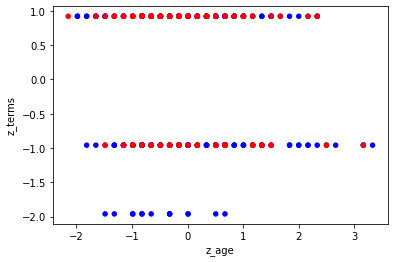

In [23]:
table.plot(x='z_age',y='z_terms',kind='scatter',color=cols)

## ML Methods Comparison
### K Nearest Neighbors

In [7]:
jKNN = []; f1KNN = []; logKNN=[]
for i in range(10) :
    KNN = neighbors.KNeighborsClassifier(n_neighbors=i+1)
    KNN.fit(xTrain,yTrain)
    yHat = KNN.predict(xTest)
    jKNN.append(metrics.jaccard_score(yHat,yTest))
    f1KNN.append(metrics.f1_score(yHat,yTest))
    logKNN.append(metrics.log_loss(yHat,yTest))

#### Evaluate KNN Performance

Peak performance is reached with 7 Nearest Neighbors:
	Jaccard = 0.6666666666666666
	F1 Score = 0.7999999999999999
	LogLoss = 11.2915922481138


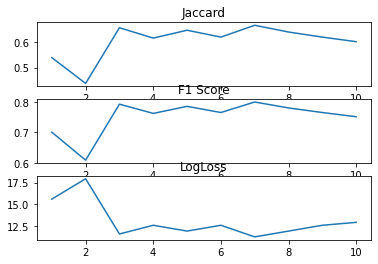

In [22]:
fig, ax= plt.subplots(3)
ax[0].plot(list(range(1,11)),jKNN)
ax[1].plot(list(range(1,11)),f1KNN)
ax[2].plot(list(range(1,11)),logKNN)
ax[0].set_title('Jaccard'); ax[1].set_title('F1 Score'); ax[2].set_title('LogLoss')
perfPeakIdx = np.where(jKNN == np.amax(jKNN))[0].item()
print('Peak performance is reached with '+str(perfPeakIdx+1)+' Nearest Neighbors:' +
      '\n\tJaccard = ' + str(jKNN[perfPeakIdx]) +
      '\n\tF1 Score = ' +str(f1KNN[perfPeakIdx]) + 
      '\n\tLogLoss = ' + str(logKNN[perfPeakIdx]))

### Decision Tree

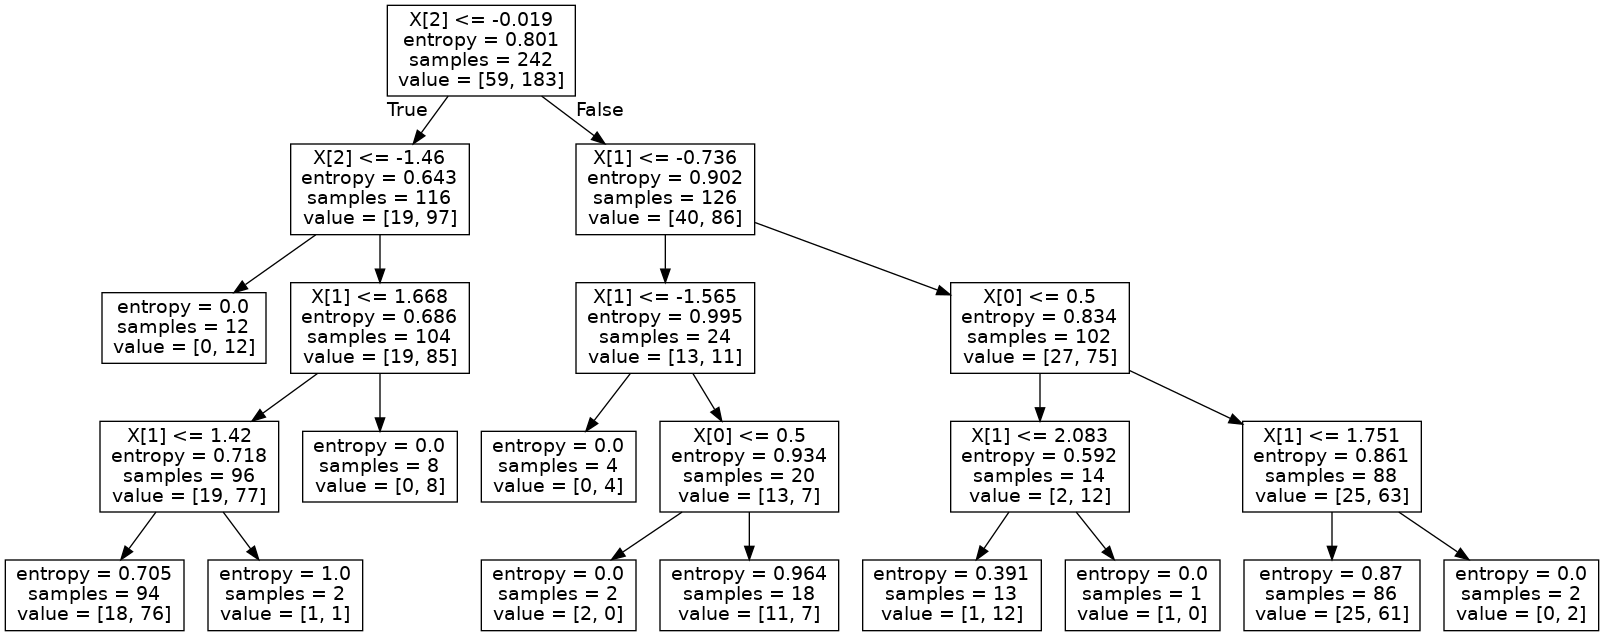

In [9]:
treeClassifier = tree.DecisionTreeClassifier(criterion='entropy',max_depth=4)
treeClassifier.fit(xTrain,yTrain)
yHat = treeClassifier.predict(xTest)
tree.export_graphviz(treeClassifier,out_file='tree.dot')
!dot -Tpng tree.dot -o tree.png
from IPython.display import Image
from IPython.core.display import HTML 
Image("tree.png", width=600, height=800)

#### Evaluate Tree Performance

In [10]:
jTree = metrics.jaccard_score(yHat,yTest)
f1Tree= metrics.f1_score(yHat,yTest)
logTree= metrics.log_loss(yHat,yTest)
print('Performance of a Tree Classifier are: ' +
      '\n\tJaccard = ' + str(jTree) +
      '\n\tF1 Score = ' +str(f1Tree) + 
      '\n\tLogLoss = ' + str(logTree))

Performance of a Tree Classifier are: 
	Jaccard = 0.64
	F1 Score = 0.7804878048780488
	LogLoss = 11.95583024022478


### SVM

In [11]:
SVM_poly = svm.SVC(kernel='poly',degree=5)
SVM_rbf = svm.SVC(kernel='rbf')
SVM_sigmoid = svm.SVC(kernel='sigmoid')
SVM_poly.fit(xTrain,yTrain)
SVM_rbf.fit(xTrain,yTrain)
SVM_sigmoid.fit(xTrain,yTrain)
yHat_poly = SVM_poly.predict(xTest)
yHat_rbf = SVM_rbf.predict(xTest)
yHat_sigmoid = SVM_sigmoid.predict(xTest)

#### Evaluate Scalable Vector Machine Performance

In [12]:
jSvm_poly = metrics.jaccard_score(yHat_poly,yTest)
jSvm_rbf = metrics.jaccard_score(yHat_rbf,yTest)
jSvm_sigmoid = metrics.jaccard_score(yHat_sigmoid,yTest)

f1Svm_poly = metrics.f1_score(yHat_poly,yTest)
f1Svm_rbf = metrics.f1_score(yHat_rbf,yTest)
f1Svm_sigmoid = metrics.f1_score(yHat_sigmoid,yTest)

logSvm_poly = metrics.log_loss(y_pred=yHat_poly,y_true=yTest)
logSvm_rbf = metrics.log_loss(y_pred=yHat_rbf,y_true=yTest)
logSvm_sigmoid = metrics.log_loss(y_pred=yHat_sigmoid,y_true=yTest)

print('Performance of a SVM Classifier depending on kernel function are: ' +
      '\n\tKernel: \tPoly\t\t\tRBF\t\t\tSigmoid' +
      '\n\tJaccard =\t' + str(jSvm_poly) + '\t' + str(jSvm_rbf) +'\t' + str(jSvm_sigmoid) +
      '\n\tF1 Score =\t' + str(f1Svm_poly) + '\t' + str(f1Svm_rbf) + '\t' + str(jSvm_sigmoid) +
      '\n\tLogLoss =\t' + str(logSvm_poly) + '\t' + str(logSvm_rbf) + '\t' + str(logSvm_sigmoid))

Performance of a SVM Classifier depending on kernel function are: 
	Kernel: 	Poly			RBF			Sigmoid
	Jaccard =	0.7403846153846154	0.7403846153846154	0.7128712871287128
	F1 Score =	0.850828729281768	0.850828729281768	0.7128712871287128
	LogLoss =	8.967005305703882	8.967005305703882	9.631189478757062


### Logistic Regression

In [13]:
log_newton = linear_model.LogisticRegression(solver='newton-cg')
log_sag = linear_model.LogisticRegression(solver='sag')
log_lbfgs = linear_model.LogisticRegression()
log_newton.fit(xTrain,yTrain)
log_sag.fit(xTrain,yTrain)
log_lbfgs.fit(xTrain,yTrain)
yHat_newton = log_newton.predict(xTest)
yHat_sag = log_sag.predict(xTest)
yHat_lbfgs = log_lbfgs.predict(xTest)

#### Evaluate Logistic Regression Performance

In [14]:
jNewton = metrics.jaccard_score(yHat_newton,yTest)
jSag = metrics.jaccard_score(yHat_sag,yTest)
jLbfgs = metrics.jaccard_score(yHat_lbfgs,yTest)

f1Newton = metrics.f1_score(yHat_newton,yTest)
f1Sag = metrics.f1_score(yHat_sag,yTest)
f1Lbfgs = metrics.f1_score(yHat_lbfgs,yTest)

logNewton = metrics.log_loss(y_pred=yHat_newton,y_true=yTest)
logSag = metrics.log_loss(y_pred=yHat_sag,y_true=yTest)
logLbfgs = metrics.log_loss(y_pred=yHat_lbfgs,y_true=yTest)

print('Performance of a SVM Classifier depending on kernel function are: ' +
      '\n\tSolver: \tNewton\t\t\tSag\t\t\tLbfgs' +
      '\n\tJaccard =\t' + str(jNewton) + '\t' + str(jSag) +'\t' + str(jLbfgs) +
      '\n\tF1 Score =\t' + str(f1Newton) + '\t' + str(f1Sag) + '\t' + str(f1Lbfgs) +
      '\n\tLogLoss =\t' + str(logNewton) + '\t' + str(logSag) + '\t' + str(logLbfgs))

Performance of a SVM Classifier depending on kernel function are: 
	Solver: 	Newton			Sag			Lbfgs
	Jaccard =	0.7403846153846154	0.7403846153846154	0.7403846153846154
	F1 Score =	0.850828729281768	0.850828729281768	0.850828729281768
	LogLoss =	8.967005305703882	8.967005305703882	8.967005305703882


### Performance Global Recap

<BarContainer object of 4 artists>

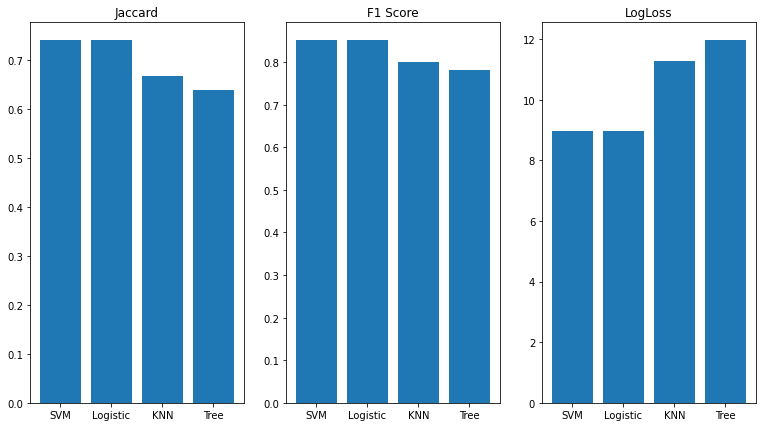

In [21]:
fig, ax = plt.subplots(1,3,figsize=(13,7))
ax[0].set_title('Jaccard'); ax[1].set_title('F1 Score'); ax[2].set_title('LogLoss')
labels = ['SVM','Logistic','KNN','Tree']
ax[0].bar(labels,[jSvm_poly,jNewton,jKNN[perfPeakIdx],jTree])
ax[1].bar(labels,[f1Svm_poly,f1Newton,f1KNN[perfPeakIdx],f1Tree])
ax[2].bar(labels,[logSvm_poly,logNewton,logKNN[perfPeakIdx],logTree])